# run spectra gene program methods in cross-sectional ALTRA data

## run Spectra model in CON1, ARI, ERA 

This notebook covers:

1. **Data Loading**: Import datasets.
2. **Construct gene program database**: Construct gene program database from Octupus to align cell type
3. **downsampling**: downsample the dataset to equal number of cells per sample
4. **Train model**: Define and train the AIM1 Spectra Crox Model.
5. **Results Analysis**: Evaluate model metrics.
6. **Saving Outputs**: Save model and results.


In [1]:
# import packages
import numpy as np
import scanpy as sc
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import pickle
# spectra imports
import Spectra as spc
from Spectra import Spectra_util as spc_tl

In [2]:
# define working path
data_path = '/home/jupyter/data/ra_longitudinal/scrna/'
fig_path = '/home/jupyter/data/ra_longitudinal/figures/Spectra/'
meta_path = '/home/jupyter/github/ra-longitudinal/metadata/'
output_path = '/home/jupyter/data/ra_longitudinal/output_results/Spectra/'

# define a project name
proj_name = 'RA_Cross_sectional_scRNA_Spectra'
# sc.set_figure_params(fig_path)
sc.settings.figdir = fig_path
sc.settings.autosave = False
sc.set_figure_params(vector_friendly=True, dpi_save=300)

# load adata

In [ ]:
# load the dataset
crox_adata = sc.read_h5ad(data_path +
                          'ALTRA_AIM1_2_crox_scRNA_filtered_cell.h5ad')

In [5]:
crox_adata

AnnData object with n_obs × n_vars = 1290371 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'S

In [5]:
# move scran_normalization to X
crox_adata.X = crox_adata.layers['scran_normalization'].copy()

In [6]:
(crox_adata.X[1:50, 1:50].toarray() ==
 crox_adata.layers['scran_normalization'][1:50, 1:50].toarray()).all()

True

# load database for gene program annotation

In [7]:
# load the default gene set dictionary from the Spectra paper:
annotations = spc.default_gene_sets.load()
annotations["global"]["all_wnt-beta-catenin-signaling"]

['HDAC2',
 'LEF1',
 'CUL1',
 'TP53',
 'GNAI1',
 'DLL1',
 'SKP2',
 'AXIN1',
 'KAT2A',
 'CSNK1E',
 'MAML1',
 'FZD8',
 'NOTCH1',
 'MYC',
 'RBPJ',
 'JAG2',
 'PTCH1',
 'PPARD',
 'HDAC5',
 'AXIN2',
 'NUMB',
 'PSEN2',
 'NKD1',
 'WNT1',
 'TCF7',
 'FRAT1',
 'HDAC11',
 'ADAM17',
 'CCND2',
 'HEY1',
 'NCSTN',
 'JAG1',
 'DVL2',
 'NOTCH4',
 'NCOR2',
 'TPTEP2-CSNK1E',
 'FZD1',
 'CTNNB1',
 'DKK4',
 'HEY2',
 'WNT6',
 'DKK1',
 'WNT5B']

In [8]:
import cytopus as cp
G = cp.KnowledgeBase()

KnowledgeBase object containing 92 cell types and 201 cellular processes



In [9]:
celltype_of_interest = ['M', 'T', 'B']
global_celltypes = ['all-cells', 'leukocyte']
G.get_celltype_processes(
    celltype_of_interest, global_celltypes=global_celltypes, get_children=True, get_parents=False)

In [10]:
list(G.graph.successors('cDC'))

['DC']

In [11]:
# dictionary of all cellular identities in KnowledgeBase as a dictionary {'identity_1':['gene_j','gene_k','gene_z',...],'identity_2':['gene_y','gene_p',...],...}
G.identities.keys()

dict_keys(['TCM', 'Treg', 'T-naive', 'B-pb-t2', 'endo-lymphatic', 'TSCM', 'cDC1', 'ILC1', 'NK-adaptive', 'TEM', 'FDC', 'endo-systemic-venous', 'endo-aerocyte', 'CD56bright-NK', 'plasma-blast', 'CD8-T_KLRG1pos-effector', 'p-DC', 'mast', 'B-memory-DN', 'B-naive', 'CD4-T', 'B-pb-t3', 'B', 'B-pb-mature', 'Mac', 'gran', 'cDC2', 'CD56dim-NK', 'TRM', 'Lti', 'ILC3-NCRpos', 'abT', 'TFH', 'mono', 'CD8-T_KLRG1neg-effector', 'B-memory-IgM-MZ', 'cDC3', 'B-memory-switched', 'ILC3-NCRneg', 'Langerhans', 'mo-DC', 'endo-arterial', 'ILC2', 'plasma', 'B-pb-t1', 'lung-endo-venous', 'gdT', 'NK', 'capillary', 'CD8-T', 'B-memory', 'B-memory-non-switched', 'GC-B'])

### Create a dictionary for Spectra aligh with aifi l2 cell type

In [13]:
crox_adata.obs['AIFI_L2'].astype('str').unique()

array(['Naive CD4 T cell', 'Treg', 'Naive CD8 T cell',
       'Memory CD4 T cell', 'Naive B cell', 'gdT', 'CD14 monocyte',
       'Memory CD8 T cell', 'ILC', 'DN T cell', 'Memory B cell',
       'Effector B cell', 'Transitional B cell', 'CD56dim NK cell',
       'MAIT', 'cDC2', 'ASDC', 'cDC1', 'CD16 monocyte',
       'Intermediate monocyte', 'Progenitor cell',
       'Proliferating NK cell', 'CD8aa', 'CD56bright NK cell',
       'Proliferating T cell', 'Erythrocyte', 'pDC', 'Plasma cell',
       'Platelet'], dtype=object)

In [14]:
# if necessary convert cell type names to names in the KnowledgeBase
# e.g. B_GC would be the name for germinal center B cells in your data
# but in the KnowledgeBase they are stored with a hyphon 'GC-B'
conversion_dict = {
    'Memory B cell': 'B-memory',
    'Naive B cell': 'B-naive',
    'Other_T': "T-naive",
    'CD4_T': 'CD4-T',
    'CD8_T': 'CD8-T',
    'ILC': 'ILC',
    'NK': 'NK',
    'Treg': 'Treg',
    'gdT': 'gdT',
    'DC': 'DC',
    'mono': 'mono',
    'Plasma cell': 'plasma'}

# to map KnowledgeBase labels back to labels in data
conversion_dict_inv = {}
for i, v in conversion_dict.items():
    conversion_dict_inv[v] = i
conversion_dict_inv['global'] = 'global'

In [15]:
conversion_dict.keys()

dict_keys(['Memory B cell', 'Naive B cell', 'Other_T', 'CD4_T', 'CD8_T', 'ILC', 'NK', 'Treg', 'gdT', 'DC', 'mono', 'Plasma cell'])

In [16]:
# define cell types to retrieve gene sets for
celltype_of_interest = conversion_dict.keys()
global_celltypes = ['all-cells', 'leukocyte']

celltype_of_interest = [conversion_dict[x] for x in celltype_of_interest]

# you can retrieve gene sets linked to the parents and children of the queried gene sets above
# you can define the query depth using a dictionary, for all cell types not defined in the dict the query depth of the
# <parent_depth> parameter will be used (proceed equivalently for children using the <child_depth> and <child_depth_dict>
# parameters)

# e.g. removing the query for parent gene sets for Treg here because this would add the
query_depth_parent = {'NK': 2, 'Treg': 1, 'DC': 2}
# T-helper polarization gene sets (TH1, TH2, TH22 etc)
query_depth_child = {'CD4-T': 2, 'ILC': None}

# retrieve dictionary for Spectra
G.get_celltype_processes(celltype_of_interest, global_celltypes=global_celltypes,
                         get_children=True, get_parents=True,
                         child_depth=1, parent_depth=1,
                         parent_depth_dict=query_depth_parent,
                         child_depth_dict=query_depth_child)

cell types of interest share the following children: ['Treg'] This may be desired.
cell types of interest share the following parents: ['B', 'abT', 'CD4-T', 'ILC', 'TNK', 'M'] This may be desired.


In [17]:
# convert celltype labels back to celltypes in data
Spectra_dict = {}
for i, v in G.celltype_process_dict.items():
    Spectra_dict[conversion_dict_inv[i]] = v

In [18]:
# add a empty category of other
Spectra_dict.update({"Other": {}})

In [41]:
Spectra_dict.keys()

dict_keys(['Memory B cell', 'Naive B cell', 'Other_T', 'CD4_T', 'CD8_T', 'ILC', 'NK', 'Treg', 'gdT', 'DC', 'mono', 'Plasma cell', 'global', 'Other'])

In [42]:
# add a pathway for Naive B cell and Memory B cell
BCR_pathway = ['MAPK3', 'HRAS', 'NFATC4', 'CD79B', 'VAV1', 'MAPK8', 'MAP2K1',
               'RAF1', 'BTK', 'ELK1', 'PLCG1', 'CALM1', 'NFATC2', 'SYK', 'RAC1',
               'SHC1', 'PPP3CA', 'NFATC3', 'GRB2', 'PRKCB', 'CALM2', 'MAPK14', 'LYN', 'PPP3CB',
               'CALM3', 'PRKCA', 'NFATC1', 'CD79A', 'MAP3K1', 'JUN', 'SOS1', 'FOS', 'PPP3CC']
Spectra_dict['Naive B cell'].update({'B_BIOCARTA_BCR_PATHWAY': BCR_pathway})
Spectra_dict['Memory B cell'].update({'B_BIOCARTA_BCR_PATHWAY': BCR_pathway})

In [47]:
# store Spectra dictionary
import json
jpath = output_path+'Spectra_dict_aifi_l1_5.json'

with open(jpath, 'w') as f:
    json.dump(Spectra_dict, f)
print('saved data to:', jpath)

saved data to: /home/jupyter/data/ra_longitudinal/output_results/Spectra/Spectra_dict_aifi_l1_5.json


In [3]:
# load Spectra dictionary
import json
jpath = output_path+'Spectra_dict_aifi_l1_5.json'
f = open(jpath, 'r')
Spectra_dict = json.loads(f.read())

In [44]:
# make the cell type match the database
crox_adata.obs['AIFI_L1_5'] = crox_adata.obs['AIFI_L2'].astype('str').copy()
crox_adata.obs.loc[crox_adata.obs['AIFI_L1_5'].str.contains(
    'CD4'), 'AIFI_L1_5'] = 'CD4_T'
crox_adata.obs.loc[crox_adata.obs['AIFI_L1_5'].str.contains(
    'CD8'), 'AIFI_L1_5'] = 'CD8_T'
crox_adata.obs.loc[crox_adata.obs['AIFI_L1_5'].isin(['DN T cell', 'MAIT',
                                                     'Proliferating T cell']), 'AIFI_L1_5'] = 'Other_T'
crox_adata.obs.loc[crox_adata.obs['AIFI_L1_5'].str.contains(
    'monocyte'), 'AIFI_L1_5'] = 'mono'
crox_adata.obs.loc[crox_adata.obs['AIFI_L1_5'].str.contains(
    'DC'), 'AIFI_L1_5'] = 'DC'
crox_adata.obs.loc[crox_adata.obs['AIFI_L1_5'].str.contains(
    'NK'), 'AIFI_L1_5'] = 'NK'
crox_adata.obs.loc[
    crox_adata.obs['AIFI_L1_5'].isin(['Naive B cell', 'Transitional B cell']),
    'AIFI_L1_5'] = 'Naive B cell'
crox_adata.obs.loc[
    crox_adata.obs['AIFI_L1_5'].isin(['Effector B cell', 'Memory B cell']),
    'AIFI_L1_5'] = 'Memory B cell'
crox_adata.obs.loc[crox_adata.obs['AIFI_L1_5'].isin(['Platelet', 'Erythrocyte', 'Progenitor cell']),
                   'AIFI_L1_5'] = 'Other'

In [7]:
crox_adata.obs['AIFI_L1_5'].unique().tolist()

['CD4_T',
 'Treg',
 'CD8_T',
 'Naive B cell',
 'gdT',
 'mono',
 'ILC',
 'Other_T',
 'Memory B cell',
 'NK',
 'DC',
 'Other',
 'Plasma cell']

In [49]:
Spectra_dict_df = pd.DataFrame.from_dict(Spectra_dict)
Spectra_dict_df['CD8_T'][Spectra_dict_df['CD8_T'].notna()].index

Index(['T_IL4_response', 'T_tcr-activation', 'T_IL21_response',
       'CD8-T_terminal-exhaustion', 'CD8-T_progenitor-exhaustion_UP',
       'CD8-T_IL12_response', 'CD8-T_tumor-reactive-like_UP'],
      dtype='object')

## run umap

In [55]:
sc.pp.highly_variable_genes(crox_adata, layer="scran_normalization")

In [56]:
crox_adata.var['highly_variable'].value_counts()

highly_variable
False    30961
True      2577
Name: count, dtype: int64

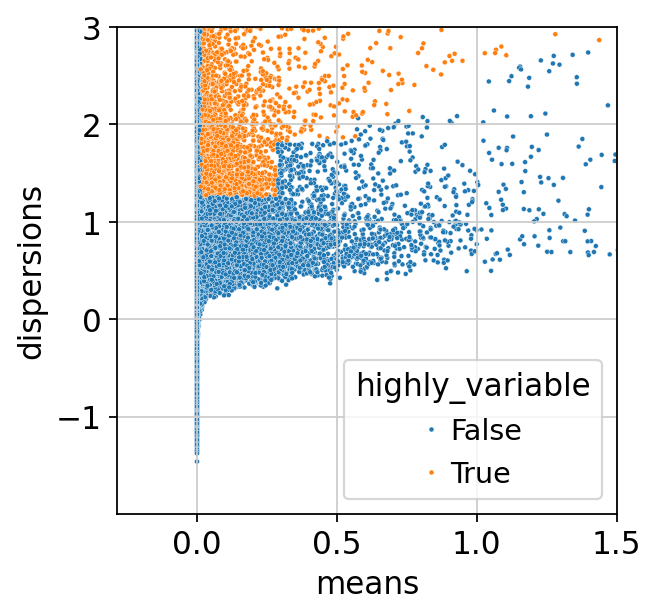

In [57]:
ax = sns.scatterplot(
    data=crox_adata.var, x="means", y="dispersions", hue="highly_variable", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

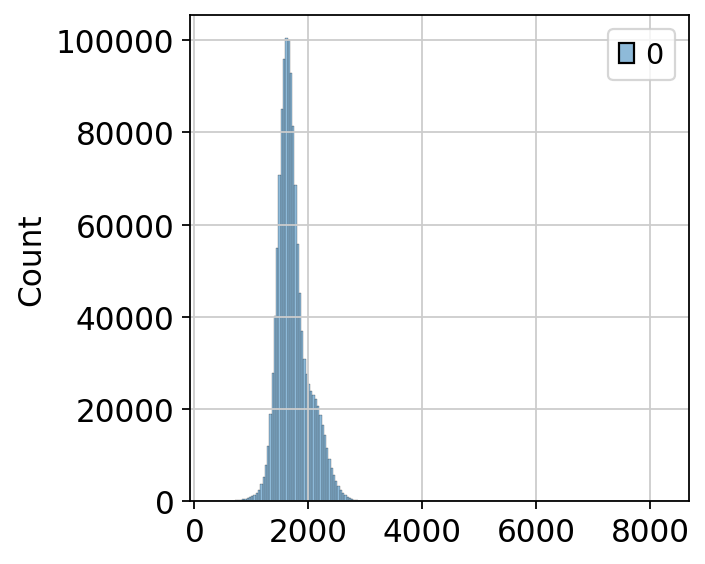

In [58]:
# plot the normalized count data
p2 = sns.histplot(
    crox_adata.layers["scran_normalization"].sum(1), bins=200, kde=False
)

In [59]:
crox_adata.obs['AIFI_L2'].unique()

['Naive CD4 T cell', 'Treg', 'Naive CD8 T cell', 'Memory CD4 T cell', 'Naive B cell', ..., 'Proliferating T cell', 'Erythrocyte', 'pDC', 'Plasma cell', 'Platelet']
Length: 29
Categories (29, object): ['ASDC', 'CD8aa', 'CD14 monocyte', 'CD16 monocyte', ..., 'cDC1', 'cDC2', 'gdT', 'pDC']

In [60]:
# # create new cell type column to align with scpetra cell types names
# crox_adata.obs['celltype_label'] = crox_adata.obs['pred_manual'].astype('str')
# crox_adata.obs.loc[crox_adata.obs['pred_manual'].str.contains('naive B'), 'celltype_label'] = 'B_naive'
# crox_adata.obs.loc[crox_adata.obs['pred_manual'].str.contains('naive CD4'), 'celltype_label'] = 'CD4_T'
# crox_adata.obs.loc[crox_adata.obs['pred_manual'].str.contains('naive CD8'), 'celltype_label'] = 'CD8_T'

In [61]:
crox_adata

AnnData object with n_obs × n_vars = 1290371 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'S

### rerun umap

In [62]:
sc.pp.pca(crox_adata, svd_solver="arpack")

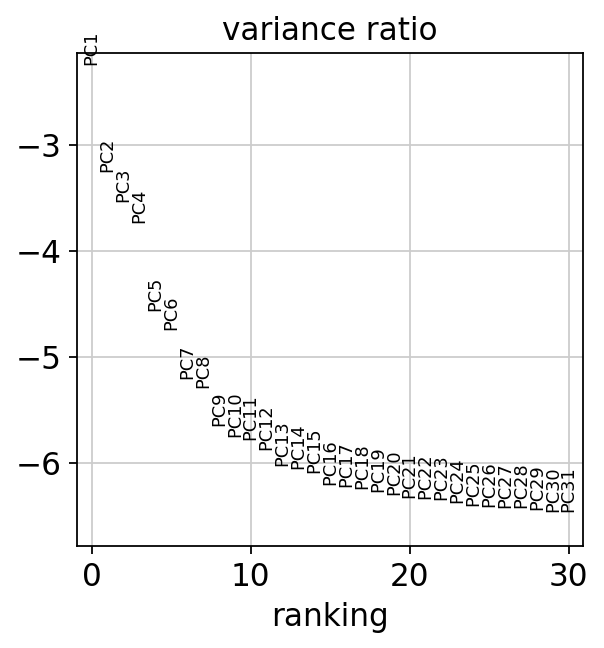

In [63]:
# plot the principle component variance explained
sc.pl.pca_variance_ratio(crox_adata, log=True)

In [68]:
sc.pp.neighbors(crox_adata,  use_rep='X_pca')
sc.tl.umap(crox_adata)

In [69]:
crox_adata

AnnData object with n_obs × n_vars = 1290371 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'S

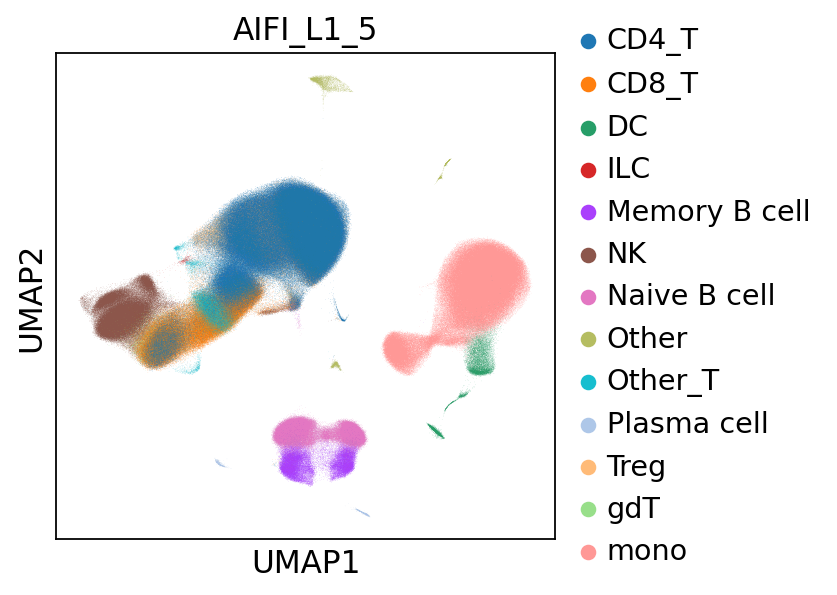

In [70]:
sc.pl.umap(crox_adata, color=['AIFI_L1_5'],
           save=proj_name+'AIFI_L1_5_umap.png')

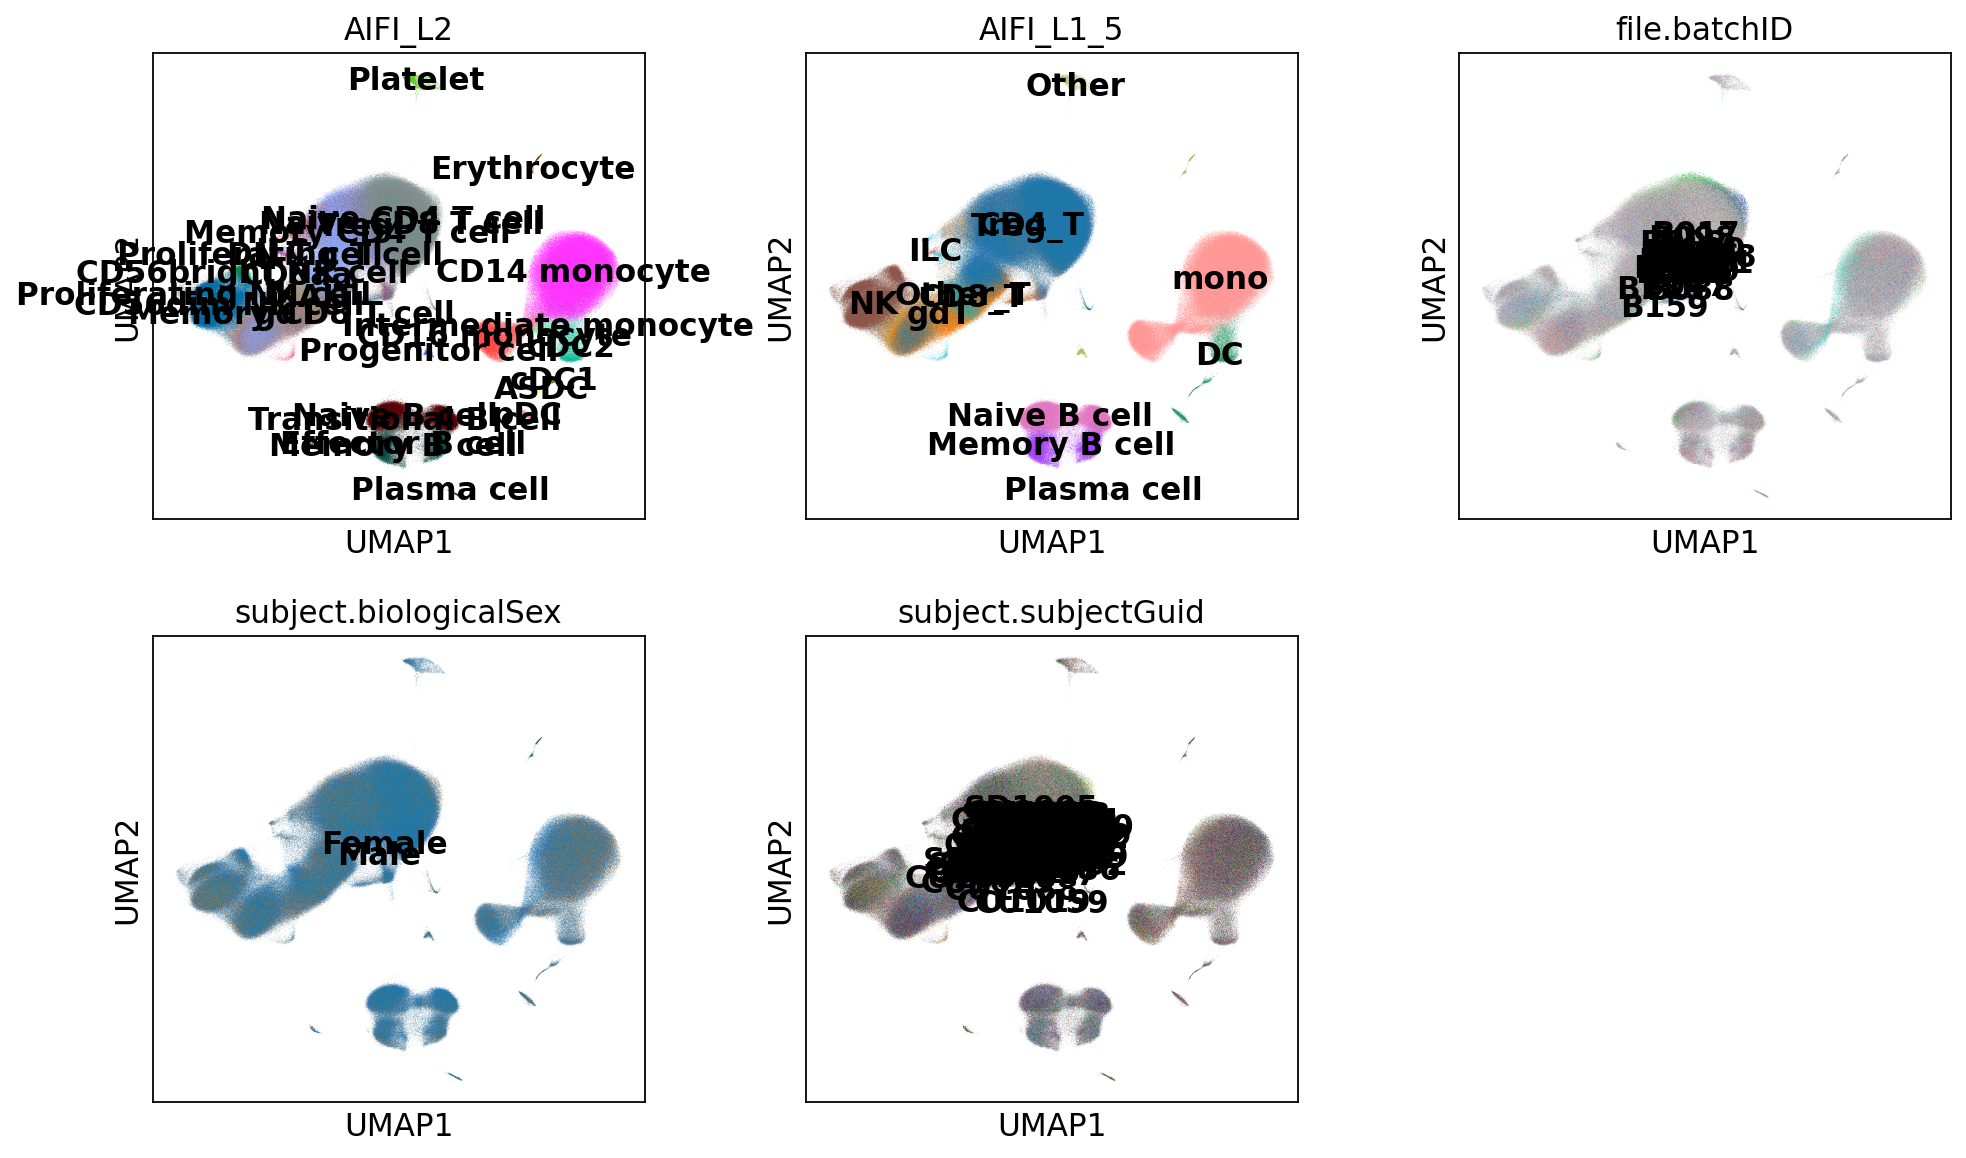

In [71]:
sc.pl.umap(crox_adata, ncols=3,
           color=['AIFI_L2', 'AIFI_L1_5', 'file.batchID',
                  'subject.biologicalSex', 'subject.subjectGuid'], legend_loc='on data',
           save=proj_name+'AIFI_L1_5_cohort_umap.png')

In [72]:
# save the dataset
crox_adata.write_h5ad(data_path + 'ALTRA_AIM1_2_crox_scRNA_filtered_cell.h5ad')

# run spectra model

In [11]:
# save the dataset
crox_adata = sc.read_h5ad(
    data_path+'ALTRA_AIM1_2_crox_scRNA_filtered_cell.h5ad')
crox_adata

AnnData object with n_obs × n_vars = 295129 × 24368
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'seurat_pbmc_type', 'seurat_pbmc_type_score', 'umap_1', 'umap_2', 'well_id', 'batch', 'Unnamed: 0', 'X', 'age', 'cell_counts', 'cohort.cohortGuid', 'file.batchID', 'file.fileType', 'file.id', 'file.majorVersion', 'file.name', 'file.panel', 'file.pool', 'lastUpdated', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'percent.mt', 'predicted.celltype.l1', 'predicted.celltype.l1.score', 'predicted.celltype.l2', 'predicted.celltype.l2.5', 'predicted.celltype.l2.5.score', 'predicted.celltype.l2.score', 'predicted.celltype.l3', 'predicted.celltype.l3.score', 'sample.bridgingControl', 'sample.daysSinceFirstVisit', 'sample.diseaseStatesRecordedAtVisit', 'sample.drawDate', 'sample.id', 'sample.sampleKitGuid', 'sample.visitDetails', 'sample.visitName', 's

In [11]:
crox_adata.obs['sample.sampleKitGuid'].value_counts()

sample.sampleKitGuid
KT00436    20969
KT03931    20741
KT00120    20428
KT00090    20259
KT00084    19718
           ...  
KT02284     8783
KT00777     7610
KT02287     7027
KT02286     6518
KT02303     6366
Name: count, Length: 88, dtype: int64

<Axes: >

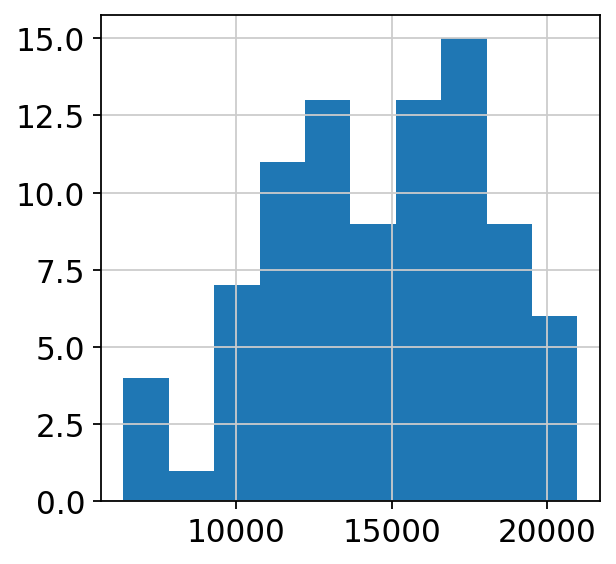

In [10]:
# get a subsample dataset to test model outcome
crox_adata.obs['sample.sampleKitGuid'].value_counts().hist()

### downsample the dataset to equal number of cells per sample

In [12]:
def obs_key_wise_subsampling(adata, obs_key, N):
    '''
    Subsample each class to the same cell numbers (N). Classes are given by obs_key pointing to a categorical variable in adata.obs.

    Parameters:
        adata (AnnData): Annotated data object containing the observations.
        obs_key (str): Key pointing to the categorical variable in adata.obs that defines the classes.
        N (int): Number of cells to subsample for each class.

    Returns:
        AnnData: A new AnnData object containing the subsampled cells.

    '''
    counts = adata.obs[obs_key].value_counts()
    # subsample indices per group defined by obs_key
    indices = [np.random.choice(adata.obs_names[adata.obs[obs_key]
                                == group], size=N, replace=False) for group in counts.index]
    selection = np.hstack(np.array(indices))
    return adata[selection].copy()

In [13]:
# subset the anndata to lowest cell number per sample
crox_sub_adata = obs_key_wise_subsampling(
    crox_adata, obs_key='sample.sampleKitGuid', N=6366)

In [14]:
crox_sub_adata

AnnData object with n_obs × n_vars = 560208 × 33538
    obs: 'barcodes', 'batch_id', 'cell_name', 'cell_uuid', 'chip_id', 'hto_barcode', 'hto_category', 'n_genes', 'n_mito_umis', 'n_reads', 'n_umis', 'original_barcodes', 'pbmc_sample_id', 'pool_id', 'well_id', 'sample.sampleKitGuid', 'cohort.cohortGuid', 'subject.subjectGuid', 'subject.biologicalSex', 'subject.race', 'subject.ethnicity', 'subject.birthYear', 'sample.visitName', 'sample.drawDate', 'sample.diseaseStatesRecordedAtVisit', 'sample.daysSinceFirstVisit', 'file.id', 'subset_grp', 'predicted_doublet', 'doublet_score', 'AIFI_L1', 'AIFI_L1_score', 'AIFI_L2', 'AIFI_L2_score', 'AIFI_L3', 'AIFI_L3_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden_harmony_2', 'doublets_manual', 'AIFI_L3_new', 'St

In [15]:
crox_sub_adata.obs['sample.sampleKitGuid'].value_counts()

sample.sampleKitGuid
KT02992    6366
KT03931    6366
KT04072    6366
KT04092    6366
KT04115    6366
           ... 
KT00057    6366
KT00058    6366
KT00060    6366
KT00063    6366
KT00064    6366
Name: count, Length: 88, dtype: int64

In [16]:
# save the dataset
crox_sub_adata.write_h5ad(
    data_path + 'ALTRA_AIM1_2_crox_scRNA_filtered_cell_downsample.h5ad')

In [74]:
# filter gene set annotation dict for genes contained in adata
annotations = spc_tl.check_gene_set_dictionary(
    crox_adata,
    Spectra_dict,
    obs_key='AIFI_L1_5',
    global_key='global')

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is now correctly formatted.


In [75]:
(crox_adata.X[1:50, 1:50].toarray() ==
 crox_adata.layers["scran_normalization"][1:50, 1:50].toarray())

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [76]:
crox_adata.X[1:50, 1:50].toarray(
) == crox_adata.layers['scran_normalization'][1:50, 1:50].toarray()

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [77]:
# run this in terminal
%%time
# fit the model (We will run this with only 2 epochs to decrease runtime in this tutorial)
model = spc.est_spectra(adata=crox_adata, 
    gene_set_dictionary=Spectra_dict, 
    use_highly_variable=True,
    cell_type_key="AIFI_L1_5", 
    use_weights=True,
    lam=0.1, # varies depending on data and gene sets, try between 0.5 and 0.001
    delta=0.001, 
    kappa=None,
    rho=0.001, 
    use_cell_types=True,
    n_top_vals=50,
    label_factors=True, 
    overlap_threshold=0.2,
    clean_gs = True, 
    min_gs_num = 3,
    num_epochs=10000 # here running only 2 epochs for time reasons, we recommend 10,000 epochs for most datasets
)

Cell type labels in gene set annotation dictionary and AnnData object are identical
Your gene set annotation dictionary is now correctly formatted.



KeyboardInterrupt



In [ ]:
# save the model
with open(output_path + 'ALTRA_AIM1_2_crox_scRNA_spectra_model.pickle', 'wb') as f:
    pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# save the dataset
crox_sub_adata.write_h5ad(
    data_path+'ALTRA_AIM1_2_crox_scRNA_filtered_cell_downsample.h5ad')

In [ ]:
crox_sub_adata